In [ ]:

import numpy as np 
import pandas as pd

from funcs.helper import get_tess_orbital_phases, get_cheops_orbital_phases

hip67522params = pd.read_csv("../data/hip67522_params.csv")

period = hip67522params[hip67522params.param=="orbper_d"].val.values[0]
midpoint = hip67522params[hip67522params.param=="midpoint_BJD"].val.values[0]
teff = hip67522params[hip67522params.param=="teff_K"].val.values[0]
tefferr = hip67522params[hip67522params.param=="teff_K"].err.values[0]
radius = hip67522params[hip67522params.param=="radius_rsun"].val.values[0]
radiuserr = hip67522params[hip67522params.param=="radius_rsun"].err.values[0]


# ----------------------------------------------------------------------------------------


cheops_phases, tcheops01, tcheops09, tot_obs_time_d_cheops = get_cheops_orbital_phases(period, midpoint, split=0.1, usemask=False)


# GET OBSERVED TESS PHASES ---------------------------------------------------------------

tess_phases, ttess01, ttess09, ttess = get_tess_orbital_phases(period, split=0.1, by_sector=False, usemask=False) 

# write phases to file
np.savetxt("../data/tess_phases.txt", tess_phases)
np.savetxt("../data/cheops_phases.txt", cheops_phases)


In [1]:

import numpy as np 

import emcee
import corner
from math import factorial
from scipy.optimize import minimize
from scipy.stats import mode

import matplotlib.pyplot as plt 

# read phases from file
tess_phases = np.loadtxt("../data/tess_phases.txt")
cheops_phases = np.loadtxt("../data/cheops_phases.txt")

# weigh by observing cadence
weights = np.concatenate([np.ones_like(cheops_phases) * 10. / 60. / 60. / 24., np.ones_like(tess_phases) * 2. / 60. / 24.] )
obs_phases = np.concatenate([cheops_phases, tess_phases])

# flare phases
phases = np.array([0.61248919, 0.81165721, 0.01788908, 0.0296636,  0.05760315, 0.04067287,
 0.73005547, 0.94878914, 0.11323833, 0.20031473, 0.15087211, 0.04514247,
 0.02527212, 0.05657772, 0.06247738, ]) 

# shift by 0.5
obs_phases = (obs_phases + 0.5) % 1
phases = (phases + 0.5) % 1

# define binning
nbins = 100
bins = np.linspace(0, 1, nbins)
binmids= (bins[1:] + bins[:-1]) / 2

# bin the phases
arr = np.digitize(obs_phases, bins)

# sum the observing times in each bin to binned weights
# unit of entries in binned is [days]
binned = np.array([np.sum(weights[arr==i]) for i in range(1, len(bins))]) 

# define the two models we want to compare
def modulated_model(binmids, lambda0, lambda1, phase0, dphase, weight=binned):
    mask = (binmids > phase0) & (binmids < (phase0 + dphase)%1)
    result = np.zeros_like(binmids)

    # multiply by weight because that modifies the measured rate
    result[~mask] = lambda0 * weight[~mask]
    result[mask] = lambda1 * weight[mask]

    return result #number of observed flares per bin

def unmodulated_model(lambda0, weight=binned):
    return lambda0 * weight #number of observed flares per bin

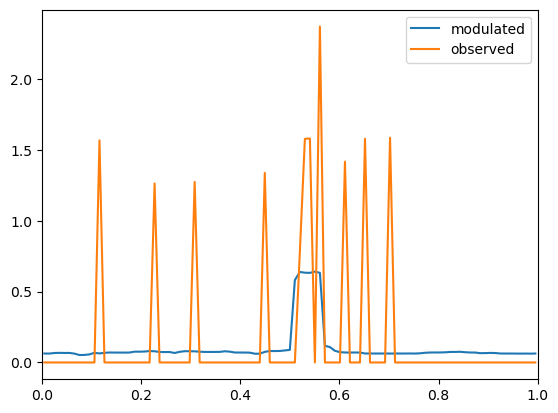

In [3]:
# FIT THE DATA --------------------------------------------------------------------------------

# initial guess
params =  [0.1, .5,  0.50, 0.07]

plt.plot(binmids, modulated_model(binmids, *params, weight=binned), label="modulated")

# observed:
hist, bins = np.histogram(phases, bins=bins)

plt.plot(binmids, hist/binned, label="observed")
plt.xlim(0, 1)
plt.legend()

In [4]:
# define the factorials for the numbers in hist for the likelihood computation
factorials = np.array([factorial(h) for h in hist])

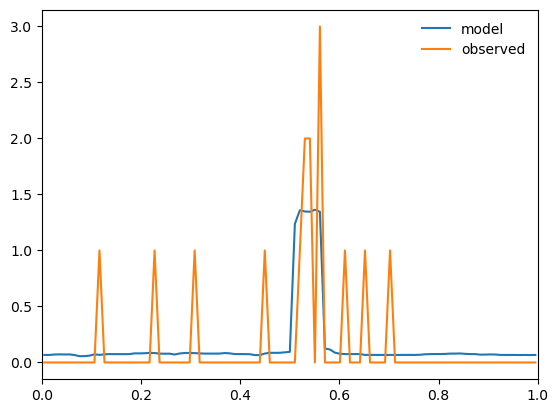

In [5]:
# Poisson log-likelihood function
def log_likelihood_poisson(rate, hist, factorials):
    logs = -rate - np.log(factorials) + np.log(rate) * hist
    return np.sum(logs)

# log-likelihood for the modulated model
def log_likelihood_mod(params):

    rate = modulated_model(binmids, *params, weight=binned)

    return log_likelihood_poisson(rate, hist, factorials)


# minimize neg. log-likelihood for a starting point in the mcmc
logmin = lambda x: -log_likelihood_mod(x)
res = minimize(logmin, params)

plt.plot(binmids, modulated_model(binmids, *res.x, weight=binned), label="model")
plt.plot(binmids, hist, label="observed")
plt.xlim(0, 1)
plt.legend(frameon=False)   

In [7]:
# define log-prior with Jeffrey's priors on Poisson rates
def log_prior_mod(params):
    if ((params[0] > 0) & (params[1] > 0) & (params[1] < 5) & ( params[0] < 5) &
        (params[2] > 0) & (params[2] < 1) & (params[3] > 0) & (params[3] < 1) ):
        return np.log(1/np.sqrt(params[0])) + np.log(1/np.sqrt(params[1])) 
    return -np.inf

# define log-probability
def log_probability_mod(params):
    lp = log_prior_mod(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_mod(params)

# MCMC --------------------------------------------------------------------------------
ndim = 4
nwalkers = 32
pos = params + 1e-4 * np.random.randn(nwalkers, ndim)

mod_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_mod)
mod_sampler.run_mcmc(pos, 30000, progress=True);


  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:17<00:00, 1715.41it/s]


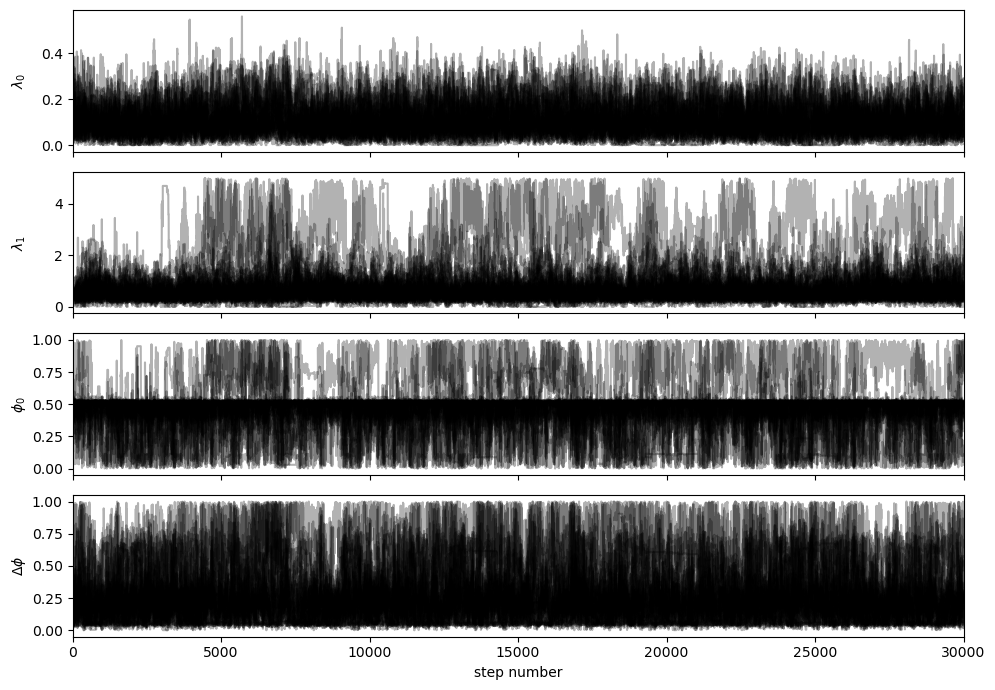

In [8]:
# plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
mod_samples = mod_sampler.get_chain()
labels = [r"$\lambda_0$", r"$\lambda_1$", r"$\phi_0$",r"$\Delta\phi$",]
for i in range(ndim):
    ax = axes[i]
    ax.plot(mod_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(mod_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")

plt.tight_layout()
plt.savefig(f"../plots/poisson_model/{nbins}_chain_modulated.png", dpi=300)

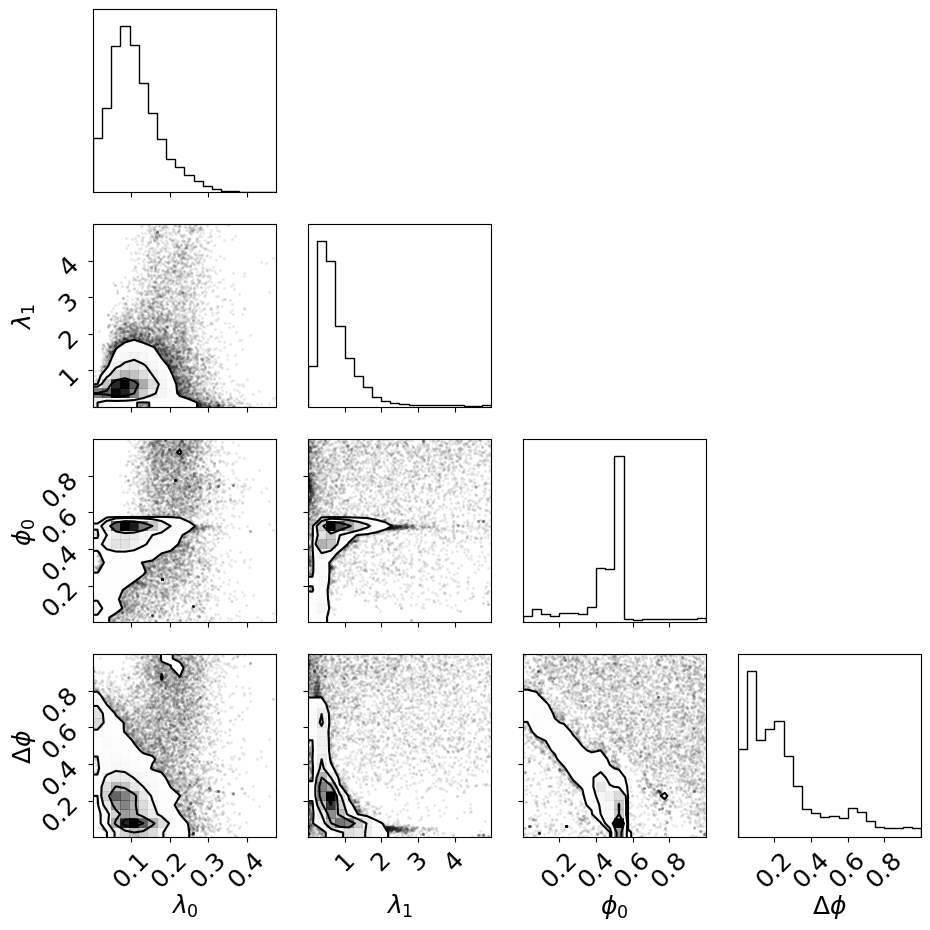

In [29]:
# plot corner
mod_flat_samples = mod_sampler.get_chain(discard=10000, thin=15, flat=True)

# increase font size to 20
plt.rcParams.update({'font.size': 18})

fig = corner.corner(mod_flat_samples, labels=labels)
plt.tight_layout()

plt.savefig(f"../plots/poisson_model/{nbins}_corner_modulated.png", dpi=300)

In [26]:
# calculate the 16th, 50th and 84th percentiles for all parameters
lambda0_mcmc = np.percentile(mod_flat_samples[:, 0], [16, 50, 84])
lambda1_mcmc = np.percentile(mod_flat_samples[:, 1], [16, 50, 84])
phi0_mcmc = np.percentile(mod_flat_samples[:, 2], [16, 50, 84])
dphi_mcmc = np.percentile(mod_flat_samples[:, 3], [16, 50, 84])

print("lambda0:", lambda0_mcmc[1], "+", lambda0_mcmc[2] - lambda0_mcmc[1], "-", lambda0_mcmc[1] - lambda0_mcmc[0])
print("lambda1:", lambda1_mcmc[1], "+", lambda1_mcmc[2] - lambda1_mcmc[1], "-", lambda1_mcmc[1] - lambda1_mcmc[0])
print("phi0:", phi0_mcmc[1], "+", phi0_mcmc[2] - phi0_mcmc[1], "-", phi0_mcmc[1] - phi0_mcmc[0])
print("dphi:", dphi_mcmc[1], "+", dphi_mcmc[2] - dphi_mcmc[1], "-", dphi_mcmc[1] - dphi_mcmc[0])


lambda0: 0.09815020120540024 + 0.06996653298773048 - 0.048124915361986126
lambda1: 0.6218301846256076 + 0.6262259656268168 - 0.28820674757479114
phi0: 0.5015851651288906 + 0.019703491597604983 - 0.14933235271685008
dphi: 0.20321517816019105 + 0.31610592853958386 - 0.1445225970961212


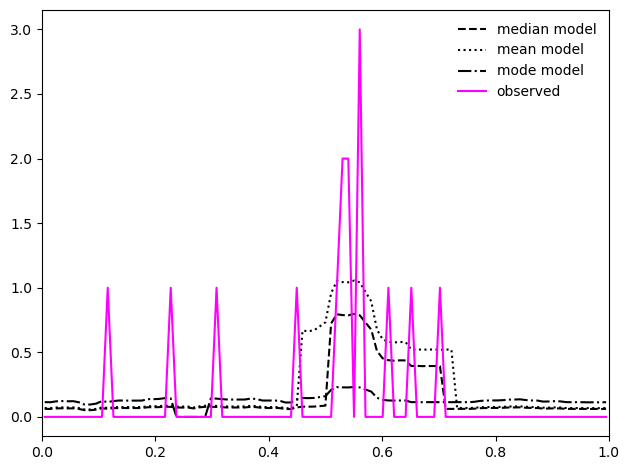

In [12]:
# get the best fit values


mod_best_median = np.array([np.median(mod_flat_samples[:, i]) for i in range(ndim)])
mod_best_mean = np.array([np.mean(mod_flat_samples[:, i]) for i in range(ndim)])
mod_best_mode = np.array([mode(mod_flat_samples[:, i])[0] for i in range(ndim)])

plt.plot(binmids, modulated_model(binmids, *mod_best_median, weight=binned), label="median model", linestyle="--", c="k")
plt.plot(binmids, modulated_model(binmids, *mod_best_mean, weight=binned), label="mean model", linestyle=":", c="k")
plt.plot(binmids, modulated_model(binmids, *mod_best_mode, weight=binned), label="mode model", linestyle="-.", c="k")
plt.plot(binmids, hist, label="observed", c="magenta")


# add text that shows the best fit values for each kind of solution in a list
mod_best_median_str = ", ".join([f"{mod_best_median[i]:.2f}" for i in range(ndim)])
mod_best_mode_str = ", ".join([f"{mod_best_mode[i]:.2f}" for i in range(ndim)])
mod_best_mean_str = ", ".join([f"{mod_best_mean[i]:.2f}" for i in range(ndim)])

# plt.text(0.05, 0.9, f"median: {mod_best_median_str}", transform=plt.gca().transAxes)
# plt.text(0.05, 0.85, f"mean: {mod_best_mean_str}", transform=plt.gca().transAxes)
# plt.text(0.05, 0.8, f"mode: {mod_best_mode_str}", transform=plt.gca().transAxes)
plt.legend(frameon=False)
plt.xlim(0,1)
plt.tight_layout()

In [14]:
# define log-likelihood, prior, and probability
def log_likelihood_unmod(params):
    lambda0 = params[0]
    rate = unmodulated_model(lambda0, weight=binned)
    return log_likelihood_poisson(rate, hist, factorials)
 
def log_prior_unmod(params):
    if ((params[0] > 0) & (params[0] < 10)):
        return np.log(1/np.sqrt(params[0]))
    return -np.inf

def log_probability_unmod(params):
    lp = log_prior_unmod(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_unmod(params)


# MCMC --------------------------------------------------------------------------------
ndim = 1
nwalkers = 32
pos = [0.5] + 1e-4 * np.random.randn(nwalkers, ndim)

unmod_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_unmod)
unmod_sampler.run_mcmc(pos, 10000, progress=True);



100%|██████████| 10000/10000 [00:04<00:00, 2387.99it/s]


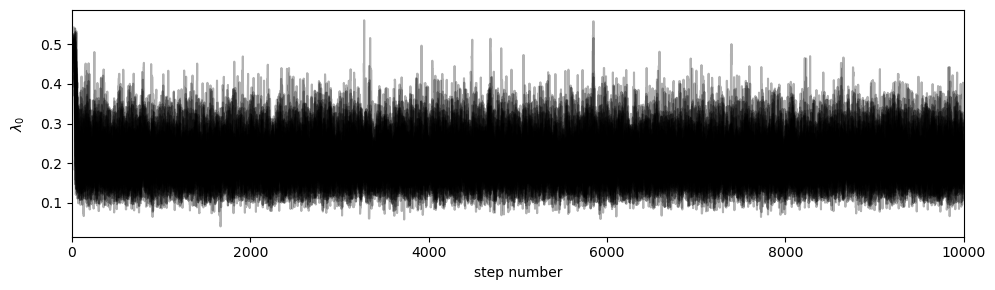

In [15]:
# plot chains
fig, axes = plt.subplots(ndim, figsize=(10, 3), sharex=True)
unmod_samples = unmod_sampler.get_chain()
unmod_label = labels[0]
axes.plot(unmod_samples[:,:,  0], "k", alpha=0.3)
axes.set_xlim(0, len(unmod_samples))
axes.set_ylabel(unmod_label)
axes.yaxis.set_label_coords(-0.05, 0.5)
axes.set_xlabel("step number")
plt.tight_layout()
plt.savefig(f"../plots/poisson_model/{nbins}_chain_unmodulated.png", dpi=300)


lambda0: 0.20630595650082684 0.058311443794904216 0.04726670715451367


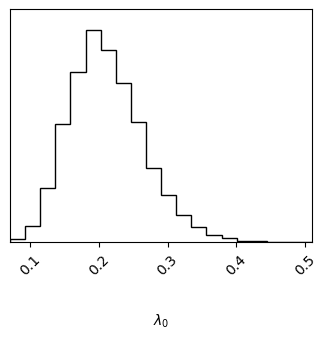

In [24]:
# corner plot
unmod_flat_samples = unmod_sampler.get_chain(discard=4000, thin=15, flat=True)

# calculate the 16th, 50th and 84th percentiles for all parameters
lambda0_mcmc = np.percentile(unmod_flat_samples[:, 0], [16, 50, 84])

print("lambda0:", lambda0_mcmc[1] ,lambda0_mcmc[2]-lambda0_mcmc[1],  lambda0_mcmc[1]-lambda0_mcmc[0])

fig = corner.corner(unmod_flat_samples, labels=[unmod_label])
plt.tight_layout()
plt.savefig(f"../plots/poisson_model/{nbins}_corner_unmodulated.png", dpi=300)

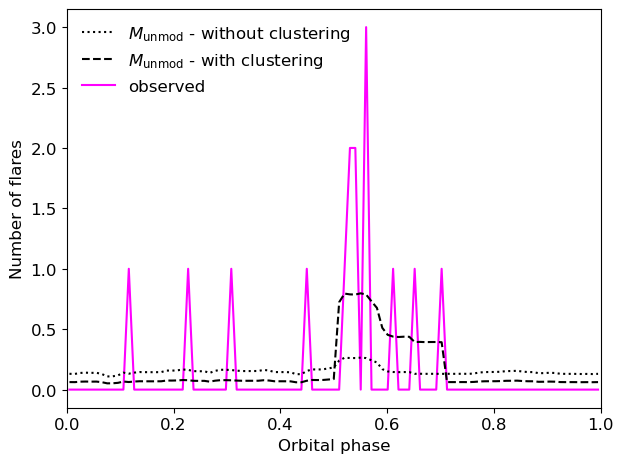

In [32]:
# get the best fit values
unmod_best_mean = np.array([np.mean(unmod_flat_samples[:, i]) for i in range(ndim)])
unmod_best_median = np.array([np.median(unmod_flat_samples[:, i]) for i in range(ndim)])

# make the fontsize small again
plt.rcParams.update({'font.size': 12})

plt.plot(binmids, unmodulated_model(*unmod_best_median), label=r"$M_{\text{unmod}}$ - without clustering", c="black", linestyle=":")
plt.plot(binmids, modulated_model(binmids, *mod_best_median), label=r"$M_{\text{unmod}}$ - with clustering", c="black", linestyle="--")
plt.plot(binmids, hist, label="observed", c="magenta", zorder=-10)
plt.legend(frameon=False)
plt.xlabel("Orbital phase")
plt.xlim(0,1)
plt.ylabel("Number of flares")
plt.tight_layout()
plt.savefig(f"../plots/poisson_model/{nbins}_best_median_fit.png", dpi=300)

In [ ]:
ranged =  [5, 10, 300, 300, 80, 80]
# ranged =  [5, 10, 400, 200, 50, 50]
# ranged = [5, 10, 300, 200, 50, 50]



lambda0max, lambda1max, lambda0n, lambda1n, phi0n, dphin = ranged
phi0 = np.linspace(0, 1, phi0n)
dphi = np.linspace(0, 1, dphin)
lambda0s = np.linspace(0, lambda0max, lambda0n)
lambda1s = np.linspace(0, lambda1max, lambda1n)
logls = np.zeros((lambda0n,lambda1n,phi0n, dphin))
for i in range(lambda0n):
    print(i)
    for j in range(lambda1n):
        for k in range(phi0n):
            for l in range(dphin):
                logl = log_probability_mod([lambda0s[i], lambda1s[j], phi0[k], dphi[l]])
                logls[i, j, k, l] = logl
integral = np.trapz(np.trapz(np.trapz(np.trapz(np.exp(logls), dphi), phi0), lambda1s), lambda0s) # trapz integrates over the last axis

logsunmod = np.zeros(lambda0n)
for i in range(lambda0n):
    logl = log_probability_unmod([lambda0s[i]])
    logsunmod[i] = logl
integralunmod = np.trapz(np.exp(logsunmod), lambda0s)

bayes_factor = integral / integralunmod


In [ ]:

with open(f"../results/bayes_factor_{nbins}.txt", "a") as f:
    string = f"{nbins},{lambda0max},{lambda1max},{lambda0n},{lambda1n},{phi0n},{dphin},{bayes_factor},{integral},{integralunmod}\n"
    f.write(string)
    print(string)


In [ ]:
integralunmod

In [ ]:
integral/integralunmod